# REFMAP laboratory listening test 1 analysis: Exploratory data analysis — Part B

## Setup

In [1]:
# import statements
import sys
import os
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from numpy.random import Generator, PCG64

In [2]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]


# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 


Set the saveplots toggle to True if plot saving is desired:

In [3]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass

## Import data and organise

In [4]:
# import data
fileExts = "*.csv"

# Part B by stimulus
dataByStimBFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataB_ByStim.csv",
                                                       caption=r"Open refmap_listest1_testdataB_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestB = pd.read_csv(dataByStimBFilePath, index_col=0)

# Part B
partBDataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataB_BySubj.csv",
                                                     caption=r"Open refmap_listest1_testdataB_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partBDataBySubj = pd.read_csv(partBDataFilePath, index_col=False)


In [5]:
# categorise columns

for dataset in [dataByStimTestB, partBDataBySubj]:
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Flyover"])
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "T150"])

## Exploratory data analysis
In this section, exploratory plots are used to examine the Par tA data for information and possible trends.

Responses are analysed using violin and scatter pl, segregating the data by the categorical variables UAS LAeq, UAS Events (quantity or density), UAS/Ambient signal-noise-ratio, and UAS type.pe.

### A function for plotting detailed violin plots with categorised data

In [6]:
def violin(data, x, y, xjitter=0, yjitter=0, yjitter_type='discrete',
           xseed=303, yseed=999, palette=None, figsize=(7, 4), alpha_pt=0.2):

    # assign figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    if palette is None:
        # assign default palette
        palette = list(mpl.colors.TABLEAU_COLORS.values())

    # get x-axis categories
    xCats = list(data[x].sort_values().unique())

    # assign y-axis data for each category
    y_data = [data[data[x] == xCat][y].values for xCat in xCats]

    # assign x-axis positions for each value in each category
    x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]

    # generate jittered x and y data using randomly distributed variables
    if yjitter != 0:
        y_jittered = [yVals + stats.t(df=20, scale=yjitter).rvs(len(yVals), random_state=Generator(PCG64(yseed)))
                      for yVals in y_data]
    else:
        y_jittered = y_data

    if xjitter != 0:
        x_jittered = list()
        for ii, xVals in enumerate(x_data):
            yVals = y_data[ii]
            xjittered = np.array(xVals).astype(float)
            yjittered = np.array(yVals).astype(float)
            if yjitter_type == 'discrete':
                # x-axis jitter is proportional to quantity of data in each set of values for discrete y data
                counts = np.array([np.sum(yVals == yVal) for yVal in np.unique(yVals)])
                counts[counts == 0] = 1
            else:
                counts = np.array([1])
            
            xjitterscaled = xjitter*counts/max(counts)
        
            for jj, yVal in enumerate(np.unique(yVals)):
                xjittered[yjittered == float(yVal)] += stats.t(df=20,
                                                             scale=xjitterscaled[jj]).rvs(len(xjittered[yjittered == float(yVal)]),
                                                                                          random_state=Generator(PCG64(xseed)))
        
            x_jittered.append(xjittered)
            
    else:
        x_jittered = x_data

    violins = ax.violinplot(y_data,
                            positions=range(0, len(xCats)),
                            widths=0.45,
                            bw_method='scott',
                            showmeans=False,
                            showmedians=False,
                            showextrema=False)
    for ii, pc in enumerate(violins["bodies"]):
        pc.set_facecolor(palette[ii])
        pc.set_edgecolor([0.25, 0.25, 0.25])
        pc.set_linewidth(1)
        pc.set_alpha(0.2)    

    medianprops = dict(linewidth=2,
                       color=[0.2, 0.2, 0.2],
                       solid_capstyle="butt")
    
    boxprops = dict(linewidth=0.75,
                    color=[0.2, 0.2, 0.2])
    
    ax.boxplot(y_data,
               positions=range(0, len(xCats)),
               showfliers=False,
               showcaps=False,
               medianprops=medianprops,
               whiskerprops=boxprops,
               boxprops=boxprops,
               widths=0.25)

    # Add jittered dots
    for xVals, yVals, color in zip(x_jittered, y_jittered, palette[0:len(xCats)]):
        ax.scatter(xVals, yVals, s=10, color='none', edgecolors=color, alpha=alpha_pt, linewidths=0.25)

    ax.set(xticks=range(0, len(xCats)), xticklabels=xCats)
    
    return fig, ax



### A function for plotting split violin plots with categorised data

In [7]:
def violinsplit(data, x, y, hue, xjitter=0, yjitter=0, yjitter_type='discrete',
                xseed=303, yseed=999, med_trace=False, palette=None, alpha_pt=0.2,
                violin_width=0.5, figsize=(7, 4.65)):

    # assign figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    if palette is None:
        # assign default palette
        palette = list(mpl.colors.TABLEAU_COLORS.values())

    if len(palette) > 2:
        palette = palette[0:2]

    # get x-axis categories
    xCats = list(data[x].sort_values().unique())
    data = data.sort_values(x)

    # get hue (split) categories
    hueCats = list(data[hue].sort_values().unique())
    
    # plot split violins
    sns.violinplot(data=data, y=y, split=True, hue=hue,
                   x=x, cut=0, palette=palette, inner='quart',
                   width=violin_width, bw_method='scott', ax=ax)

    plt.setp(ax.collections, alpha=0.2)

    shiftVal = 0.055
    
    # Add jittered dots
    y_subdataA = list()
    y_subdataB = list()
    for ii in range(0, len(xCats)):
        y_subdataA.append(data.loc[(data[hue] == hueCats[0]) &
                                   (data[x] == xCats[ii]), y].values)
        y_subdataB.append(data.loc[(data[hue] == hueCats[1]) &
                                   (data[x] == xCats[ii]), y].values)
    x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
    x_subdataB = [np.array([i] * len(d)) for i, d in enumerate(y_subdataB)]

    if yjitter != 0:
        y_Ajittered = [yVals + stats.t(df=20, scale=yjitter).rvs(len(yVals), random_state=Generator(PCG64(yseed)))
                       for yVals in y_subdataA]
        y_Bjittered = [yVals + stats.t(df=20, scale=yjitter).rvs(len(yVals), random_state=Generator(PCG64(yseed)))
                       for yVals in y_subdataB]
    else:
        y_Ajittered = y_subdataA
        y_Bjittered = y_subdataB

    if xjitter != 0:
        # jitter the first hue side
        x_Ajittered = list()
        for ii, xVals in enumerate(x_subdataA):
            yVals = y_subdataA[ii]
            xjittered = np.array(xVals).astype(float)
            yjittered = np.array(yVals).astype(float)
            if yjitter_type == 'discrete' and yVals.size != 0:
                # x-axis jitter is proportional to quantity of data in each set of values for discrete y data
                counts = np.array([np.sum(yVals == yVal) for yVal in np.unique(yVals)])
                counts[counts == 0] = 1
            else:
                counts = np.array([1])
            
            xjitterscaled = xjitter*counts/max(counts)
        
            for jj, yVal in enumerate(np.unique(yVals)):
                xjittered[yjittered == float(yVal)] += (stats.t(df=30,
                                                              scale=xjitterscaled[jj]).rvs(len(xjittered[yjittered == float(yVal)]),
                                                                                           random_state=Generator(PCG64(xseed)))
                                                      - shiftVal*np.sqrt(counts[jj]/max(counts)))
                
                # ensure no points cross the split point
                xjittered = np.minimum(xVals, xjittered)
                try:
                    xjittered[xjittered == xVals[0]] = xjittered[xjittered == xVals[0]] - shiftVal/10
                except:
                    pass
        
            x_Ajittered.append(xjittered)

        # jitter the second hue side
        x_Bjittered = list()
        for ii, xVals in enumerate(x_subdataB):
            yVals = y_subdataB[ii]
            xjittered = np.array(xVals).astype(float)
            yjittered = np.array(yVals).astype(float)
            if yjitter_type == 'discrete' and yVals.size != 0:
                # x-axis jitter is proportional to quantity of data in each set of values for discrete y data
                counts = np.array([np.sum(yVals == yVal) for yVal in np.unique(yVals)])
                counts[counts == 0] = 1
            else:
                counts = np.array([1])
            
            xjitterscaled = xjitter*counts/max(counts)
        
            for jj, yVal in enumerate(np.unique(yVals)):
                xjittered[yjittered == float(yVal)] += (stats.t(df=30,
                                                              scale=xjitterscaled[jj]).rvs(len(xjittered[yjittered == float(yVal)]),
                                                                                           random_state=Generator(PCG64(xseed)))
                                                      + shiftVal*np.sqrt(counts[jj]/max(counts)))
                
                # ensure no points cross the split point
                xjittered = np.maximum(xVals, xjittered)
                try:
                    xjittered[xjittered == xVals[0]] = xjittered[xjittered == xVals[0]] + shiftVal/10
                except:
                    pass
        
            x_Bjittered.append(xjittered)
    
    else:
        x_Ajittered = x_subdataA - shiftVal
        x_Bjittered = x_subdataB + shiftVal
        
    for xVals, yVals in zip(x_Ajittered, y_Ajittered):
        ax.scatter(xVals, yVals, s=10, color='none', edgecolors=palette[0], alpha=alpha_pt, linewidths=0.25)
    for xVals, yVals in zip(x_Bjittered, y_Bjittered):
        ax.scatter(xVals, yVals, s=10, color='none', edgecolors=palette[1], alpha=alpha_pt, linewidths=0.25)

    # add median tracing lines
    ax.plot([np.median(xVals, axis=0) - shiftVal for xVals in x_subdataA if xVals.size != 0],
            [np.median(yVals, axis=0) for yVals in y_subdataA if yVals.size != 0], ':', color=palette[0], alpha=0.3,
            linewidth=2)
    ax.plot([np.median(xVals, axis=0) + shiftVal for xVals in x_subdataB if xVals.size != 0],
            [np.median(yVals, axis=0) for yVals in y_subdataB if yVals.size != 0], ':', color=palette[1], alpha=0.3,
            linewidth=2)
    
    ax.set(xticks=range(0, len(xCats)), xticklabels=xCats)
    
    ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11)
    
    return fig, ax


Plot by LAeq

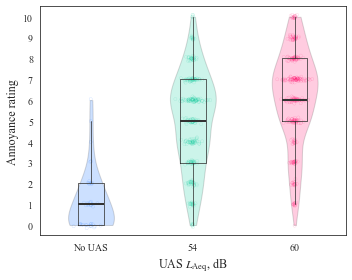

In [9]:
fig, ax = violin(partBDataBySubj, x='UASLAeq', y='Annoyance', xjitter=0.06, yjitter=0.06,
                 palette=mycolours, figsize=(5, 4), alpha_pt=0.3)

ax.set(yticks=range(0, 11), xlabel="UAS $L_\\text{Aeq}$, dB",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBAnnoyByLAeq.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBAnnoyByLAeq.pdf"),
                format='pdf')

plt.show()

The LAeq plot indicates that there is an increase in annoyance with sound level, irrespective of event quantity.)

Plot by events quantities (and densities).

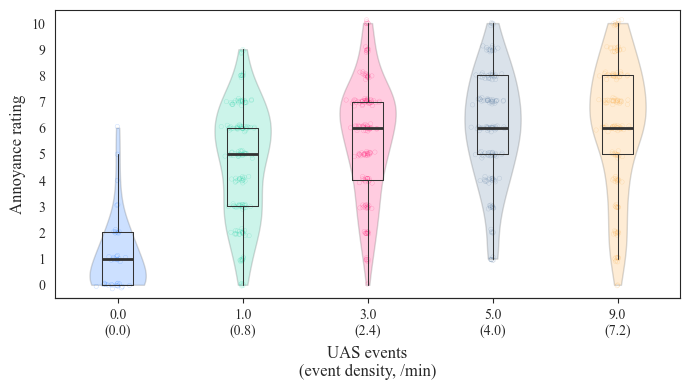

In [8]:
fig, ax = violin(partBDataBySubj, x='UASEvents', y='Annoyance', xjitter=0.06, yjitter=0.06,
                 palette=mycolours, alpha_pt=0.3)

# add second x-axis
UASEventCats = list(partBDataBySubj['UASEvents'].sort_values().unique().astype(int))
secx = ax.secondary_xaxis(location=0)
secx.set_xticks(range(0, len(UASEventCats)), labels=["\n(" + str(round(x/75*60, 1)) + ")" for x in UASEventCats])

ax.set(yticks=range(0, 11), xlabel="\nUAS events\n(event density, /min)",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBAnnoyByEvents.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBAnnoyByEvents.pdf"),
                format='pdf')

plt.show()

The plot by events suggests that annoyance increases with event quantity, but approaches a saturation point at which increasing event quantity does not increase annoyance further.

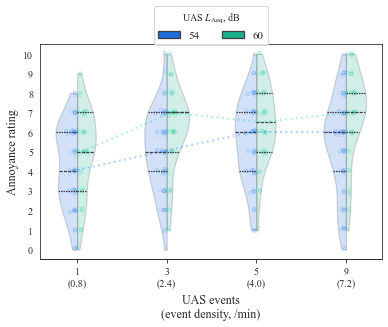

In [12]:
# segregated by LAeq

data = partBDataBySubj.loc[partBDataBySubj['UASEvents'] > 0, :].sort_values('UASEvents')
data['UASLAeq'] = pd.Categorical(data['UASLAeq'], ["54", "60"])

fig, ax = violinsplit(data=data, x='UASEvents', y='Annoyance', hue='UASLAeq',
                      xjitter=0.04, yjitter=0.06, med_trace=True,
                      xseed=6565656, palette=mycolours, figsize=(5.5, 4.65), alpha_pt=0.4)

# add second x-axis
UASEventCats = list(data['UASEvents'].sort_values().unique().astype(int))
secx = ax.secondary_xaxis(location=0)
secx.set_xticks(range(0, len(UASEventCats)), labels=["\n(" + str(round(x/75*60, 1)) + ")" for x in UASEventCats])

ax.set(yticks=range(0, 11), xlabel="\nUAS events\n(event density, /min)",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])

ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11,
          title="UAS $L_\\mathrm{Aeq}$, dB")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBAnnoyByEventsByLAeq.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBAnnoyByEventsByLAeq.pdf"),
                format='pdf')

plt.show()

Segregated by LAeq, the events plot seems to show that the 'saturation point' may occur at different event quantities for each LAeq level; the higher level reaching saturation more quickly.

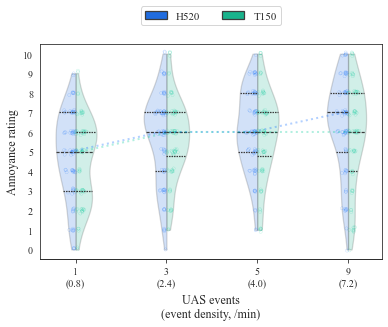

In [13]:
# segregated by UAS type

data = partBDataBySubj.loc[partBDataBySubj['UASEvents'] > 0, :].sort_values('UASEvents')
data['UASType'] = pd.Categorical(data['UASType'], ["H520", "T150"])

fig, ax = violinsplit(data=data, x='UASEvents', y='Annoyance', hue='UASType',
                      xjitter=0.04, yjitter=0.06, med_trace=True,
                      xseed=6565656, palette=mycolours, figsize=(5.5, 4.65), alpha_pt=0.4)

# add second x-axis
UASEventCats = list(data['UASEvents'].sort_values().unique().astype(int))
secx = ax.secondary_xaxis(location=0)
secx.set_xticks(range(0, len(UASEventCats)), labels=["\n(" + str(round(x/75*60, 1)) + ")" for x in UASEventCats])

ax.set(yticks=range(0, 11), xlabel="\nUAS events\n(event density, /min)",
       ylabel="Annoyance rating", ylim=[-0.5, 10.5])

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBAnnoyByEventsByType.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBAnnoyByEventsByType.pdf"),
                format='pdf')

plt.show()

Segregated by UAS type, the event plot indicates that there isn't much difference between the two UAS types. 

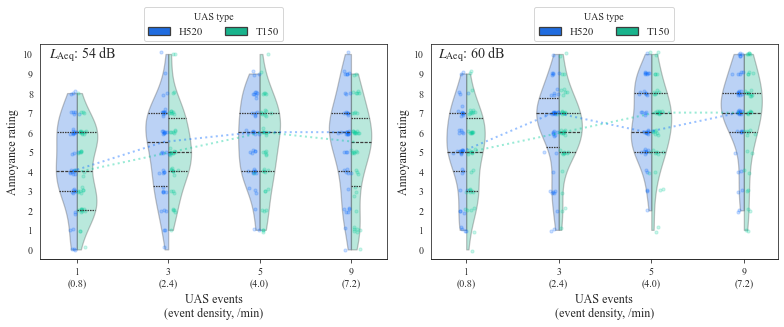

In [14]:
# segregated by UAS LAeq and type

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 4.65))
UASLAeqs = ["54", "60"]
for iiLAeq, ax in enumerate(axs):
    data = partBDataBySubj.loc[np.logical_and(partBDataBySubj['UASEvents'] > 0,
                                              partBDataBySubj['UASLAeq'] == UASLAeqs[iiLAeq]),
    ['UASEvents', 'UASLAeq', 'UASType', 'Annoyance']]
    
    data = data.sort_values('UASEvents')
    data['UASType'] = pd.Categorical(data['UASType'], ["H520", "T150"])
    
    UASEventCats = list(data['UASEvents'].sort_values().unique().astype(int))
    UASTypeCats = list(data['UASType'].sort_values().unique())
    
    sns.violinplot(data=data, y='Annoyance', split=True, hue='UASType',
                   x='UASEvents', cut=0, palette=mycolours[0:len(UASTypeCats)],
                   inner='quart', width=0.5, bw_method='scott', ax=ax)
    
    plt.setp(ax.collections, alpha=0.3)
    # Add jittered dots
    xjitter = 0.02
    yjitter = 0.06
    y_subdataA = list()
    y_subdataB = list()
    for jjEvent in range(0, len(UASEventCats)):
        y_subdataA.append(data.loc[np.logical_and(data['UASType'] == "H520",
                                                  data['UASEvents'] == UASEventCats[jjEvent]),
                          'Annoyance'].values)
        y_subdataB.append(data.loc[np.logical_and(data['UASType'] == "T150",
                                                  data['UASEvents'] == UASEventCats[jjEvent]),
                           'Annoyance'].values)
    x_subdataA = [np.array([i] * len(d)) for i, d in enumerate(y_subdataA)]
    x_subdataB = [np.array([i] * len(d))
                       for i, d in enumerate(y_subdataB)]
    x_Ajittered = [x - 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                      for x in x_subdataA]
    y_Ajittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                      for y in y_subdataA]
    x_Bjittered = [x + 0.05 + stats.t(df=6, scale=xjitter).rvs(len(x))
                        for x in x_subdataB]
    y_Bjittered = [y + stats.t(df=6, scale=yjitter).rvs(len(y))
                        for y in y_subdataB]
    for x, y in zip(x_Ajittered, y_Ajittered):
        ax.scatter(x, y, s=10, color=mycolours[0], alpha=0.2)
    for x, y in zip(x_Bjittered, y_Bjittered):
        ax.scatter(x, y, s=10, color=mycolours[1], alpha=0.2)
    
    ax.plot(np.median(x_subdataA, axis=1) - 0.05,
            np.median(y_subdataA, axis=1), ':', color=mycolours[0], alpha=0.4,
            linewidth=2)
    ax.plot(np.median(x_subdataB, axis=1) + 0.05,
            np.median(y_subdataB, axis=1), ':', color=mycolours[1], alpha=0.4,
            linewidth=2)
    
    ax.set(yticks=range(0, 11), xticks=range(0, len(UASEventCats)),
           xticklabels=UASEventCats, xlabel="\nUAS events\n(event density, /min)",
           ylabel="Annoyance rating", ylim=[-0.5, 10.5])
    ax.text(-0.3, 10-0.2, "$L_\mathrm{Aeq}$: " + UASLAeqs[iiLAeq] + " dB", fontsize=14)

    # add second x-axis
    secx = ax.secondary_xaxis(location=0)
    secx.set_xticks(range(0, len(UASEventCats)), labels=["\n(" + str(round(x/75*60, 1)) + ")" for x in UASEventCats])
    
    ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11,
              title="UAS type")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "PtBAnnoyByEventsByTypeByLAeq.svg"),
                format='svg')
plt.show()

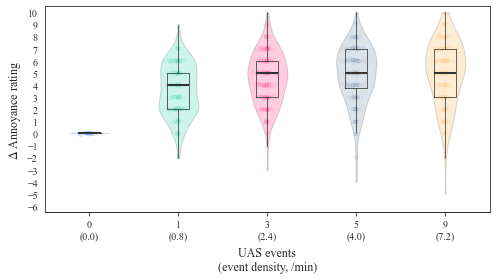

In [15]:
fig, ax = violin(partBDataBySubj, x='UASEvents', y='dAnnoyance', xjitter=0.06, yjitter=0.06,
                 palette=mycolours, alpha_pt=0.3)

# add second x-axis
UASEventCats = list(partBDataBySubj['UASEvents'].sort_values().unique().astype(int))
secx = ax.secondary_xaxis(location=0)
secx.set_xticks(range(0, len(UASEventCats)), labels=["\n(" + str(round(x/75*60, 1)) + ")" for x in UASEventCats])

ax.set(yticks=range(-8, 11), xlabel="\nUAS events\n(event density, /min)",
       ylabel="$\\Delta$ Annoyance rating", ylim=[-6.5, 10.5])

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBdAnnoyByEvents.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBdAnnoyByEvents.pdf"),
                format='pdf')

plt.show()

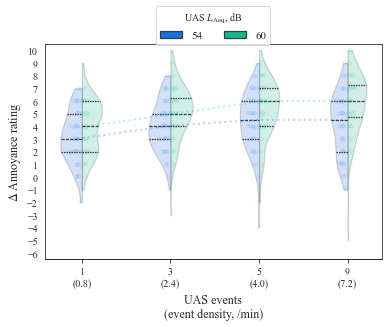

In [16]:
data = partBDataBySubj.loc[partBDataBySubj['UASEvents'] > 0, :].sort_values('UASEvents')
data['UASLAeq'] = pd.Categorical(data['UASLAeq'], ["54", "60"])

fig, ax = violinsplit(data=data, x='UASEvents', y='dAnnoyance', hue='UASLAeq',
                      xjitter=0.04, yjitter=0.06, med_trace=True,
                      palette=mycolours, figsize=(5.5, 4.65))

# add second x-axis
UASEventCats = list(data['UASEvents'].sort_values().unique().astype(int))
secx = ax.secondary_xaxis(location=0)
secx.set_xticks(range(0, len(UASEventCats)), labels=["\n(" + str(round(x/75*60, 1)) + ")" for x in UASEventCats])

ax.set(yticks=range(-8, 11), xlabel="\nUAS events\n(event density, /min)",
       ylabel="$\\Delta$ Annoyance rating", ylim=[-6.5, 10.5])

ax.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=2, fontsize=11,
          title="UAS $L_\\mathrm{Aeq}$, dB")

if saveplots:
    plt.savefig(os.path.join(outFigPath, "svg", "PtBdAnnoyByEventsByLAeq.svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", "PtBdAnnoyByEventsByLAeq.pdf"),
                format='pdf')

plt.show()

## Intermittency ratio

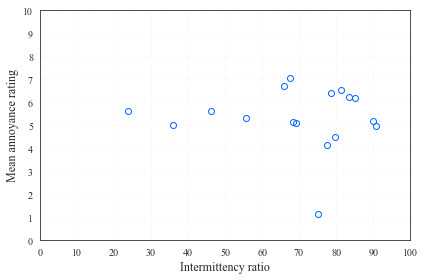

In [27]:

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dataByStimTestB.intermitRatioMaxLR, dataByStimTestB.AnnoyMean,
        linewidth=0, marker='o', color=mycolours[0],
        markerfacecolor='none')
ax.set(xlabel="Intermittency ratio", ylabel="Mean annoyance rating",
       xticks=np.arange(0, 110, 10), yticks=range(0, 11))
ax.grid(alpha=0.15, linestyle='--')
plt.show()

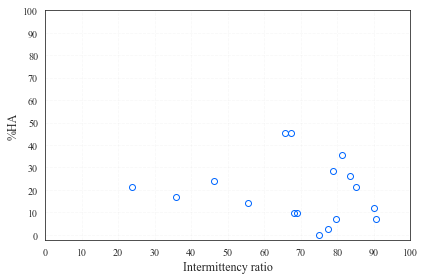

In [26]:

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dataByStimTestB.intermitRatioMaxLR, dataByStimTestB.HighAnnoyProportion,
        linewidth=0, marker='o', color=mycolours[0],
        markerfacecolor='none')
ax.set(xlabel="Intermittency ratio", ylabel="%HA",
       xticks=np.arange(0, 110, 10), yticks=np.arange(0, 1.1, 0.1),
       yticklabels=np.arange(0, 110, 10))
ax.grid(alpha=0.15, linestyle='--')
plt.show()

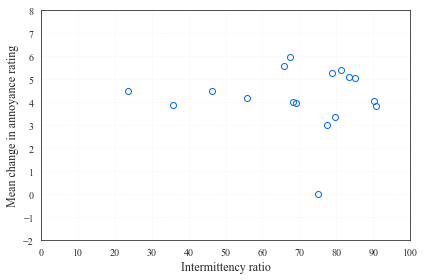

In [31]:

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dataByStimTestB.intermitRatioMaxLR, dataByStimTestB.dAnnoyMean,
        linewidth=0, marker='o', color=mycolours[0],
        markerfacecolor='none')
ax.set(xlabel="Intermittency ratio", ylabel="Mean change in annoyance rating",
       xticks=np.arange(0, 110, 10), yticks=np.arange(-2, 9))
ax.grid(alpha=0.15, linestyle='--')
plt.show()